#  Logistic Regression and Classification Error Metrics
### Grupo:
#### Arthur Lopes Sabioni
#### Júlia Bindi Alencar de Jesus

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website: above or at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones 

In [1]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
data_path = ['data']

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [2]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [3]:
data.dtypes.value_counts()

float64    561
object       1
Name: count, dtype: int64

In [4]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [5]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
Name: count, dtype: int64

In [6]:
data.iloc[:, :-1].max().value_counts()

1.0    561
Name: count, dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [7]:
data.Activity.value_counts()

Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

7341     5
9234     2
10289    5
5097     2
90       3
Name: Activity, dtype: int32

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [9]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

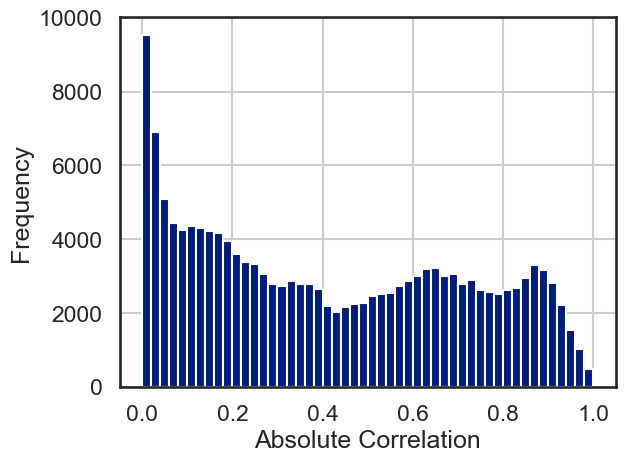

In [11]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [12]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']


In [14]:
y_train.value_counts(normalize=True)

Activity
0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: proportion, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

Activity
0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: proportion, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [16]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(max_iter=500, penalty='none').fit(X_train, y_train)
lr.coef_

c:\Users\Arthur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


array([[ -70.46411751,   11.50831385,   16.03988714, ...,  656.3317196 ,
        -261.07692642,  -74.1520117 ],
       [-227.94742476,  -93.70794333,   24.93989875, ...,  -70.75146987,
        -112.97043853,  -75.24968207],
       [ 101.49630878,   74.08094378,   79.13581328, ..., -272.87419559,
         207.66414408,   20.79781382],
       [   3.89933235,  -15.92475574,    0.93760201, ..., -120.31477598,
          17.09375714,   62.41295403],
       [ 135.27116962,   29.61808866,    2.43421879, ..., -233.0977515 ,
         -15.9011069 ,   -9.30875861],
       [  57.74473151,   -5.57464722, -123.48741997, ...,   40.70647335,
         165.19057063,   75.49968453]])

In [17]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [18]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

In [19]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train, y_train)

Análise: Foram feitas as regressões lineares do problema, agora utilizando as penalidades L1 e L2.

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [20]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

#for lab,mod in zip(coeff_labels, coeff_models):
#    coeffs = mod.coef_
#    levels=[[lab], [0,1,2,3,4,5]]
#    labels=[[0,0,0,0,0,0], [0,1,2,3,4,5]]
#    coeff_label = pd.MultiIndex(levels,labels)
#    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)



lr                                                               
              0           1           2           3           4           5   
50   286.740640  193.557938 -265.890997  -23.349885   25.163725 -216.221420  \
124  -57.500702  -98.698164  -15.546098  125.276729  -21.654156   68.122391   
231  -85.387008  -54.068329  -96.192829  126.372920   52.580340   56.694906   
144  -50.433516  -83.855989  -70.229927   39.295428   56.859278  108.364725   
15   -45.957928 -111.488490  -42.154658   65.653687   57.001103   76.946286   
65    -5.352025  -18.797624  107.842881  169.662206 -234.119413  -19.236025   
271  -66.596831 -164.196046  -60.816258   30.805561   79.799906  181.003669   
286  -45.048629   85.183982 -132.006548  -37.613921  173.684262  -44.199146   
293   71.199682   41.643668   26.348094   17.488179  -82.465214  -74.214408   
502  -32.915905  -27.102107 -118.703669  -72.009818  258.707961   -7.976461   

           l1                                                          l2   
            0         1         2         3         4         5         0   
50  -0.209349  0.000000  0.000000  0.216095  0.000000 -5.476944  3.124473  \
124  0.044539  0.000000  0.000000  0.589057 -1.017342 -0.009965 -0.022429   
231 -0.083911  0.000000  0.000000  0.643695  0.000000 -0.266728 -0.094395   
144 -0.289837  0.000000  0.039365  1.865887  0.000000 -0.170743  0.178316   
15   0.011210 -0.497528 -0.088051 -1.810212  0.000000 -2.254751  0.014152   
65   0.151039  0.000000  0.000000  1.211108 -1.103579  0.190817 -0.123619   
271  0.004716 -1.319410 -0.738410 -1.177477  0.000000  3.063342 -0.019530   
286 -0.078427  0.000000  0.000000 -0.154709  1.130355 -0.812535 -0.106925   
293  0.380639  0.000000  0.000000 -1.223637 -1.814934 -1.524627  0.579839   
502  0.113086  0.000000 -0.746893 -2.598050  2.847266 -3.326748  0.024110   

                                                       
            1         2         3         4         5  
50   3.149401 -6.099583  0.269475  0.720601 -1.164367  
124 -1.408636  1.004530  0.648350 -0.545564  0.323749  
231  0.068786 -0.614467  0.571229  0.002181  0.066667  
144 -0.436439 -0.204334 -0.023965  0.112873  0.373550  
15  -0.617303  0.165138 -0.086762  0.173535  0.351240  
65  -1.083816  1.689498  0.758269 -1.017219 -0.223113  
271 -1.620468  0.711342 -0.397752  0.349713  0.976695  
286  3.141421 -3.293899 -0.396138  0.989720 -0.334179  
293 -0.091673  0.165220  0.399493 -0.500514 -0.552365  
502  0.464499 -0.813542 -1.051675  1.636122 -0.259513

Prepare six separate plots for each of the multi-class coefficients.

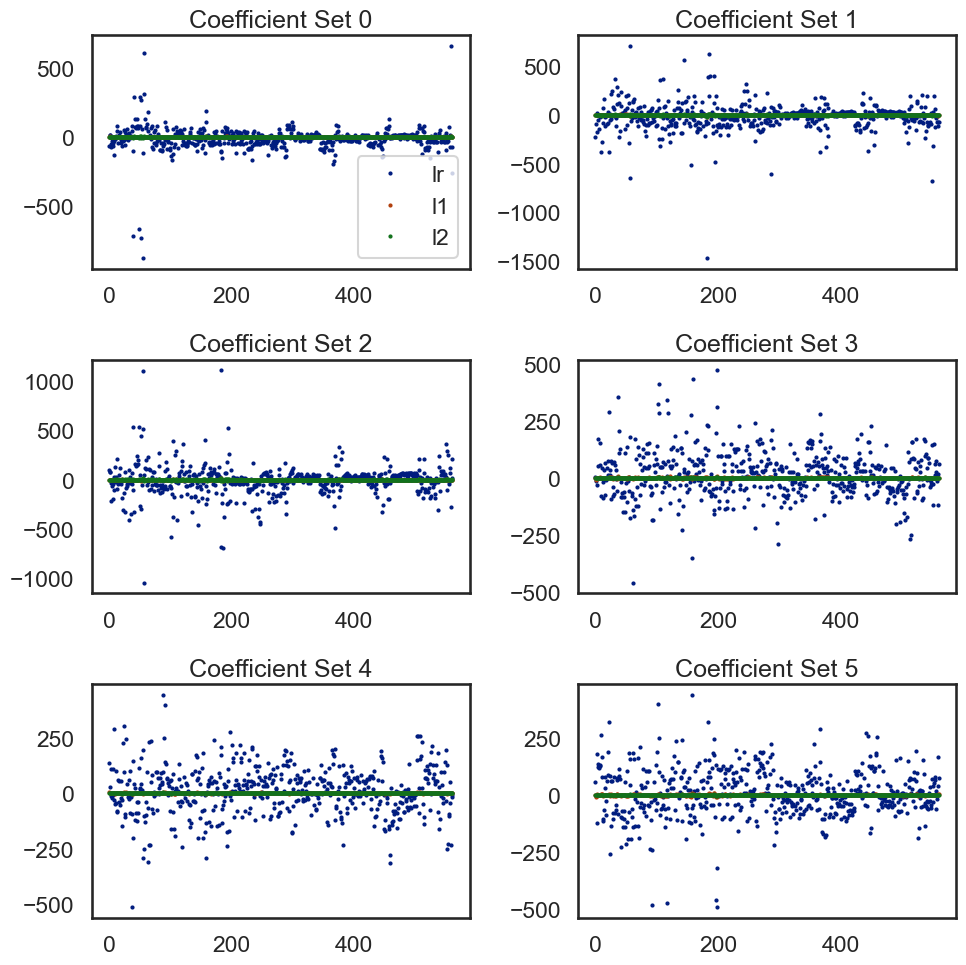

In [21]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data_aux = coefficients.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()




Análise: Foram plotados todos os coeficientes das regressões geradas, podendo ver que os de l1 e l2 são muitas vezes jogados para zero ou muito próximos disso, e os de lr estão espalhados por todos os valoes

## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [22]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()



,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [23]:
y_prob.head()

,lr,l1,l2
0,1.0,0.998993,1.000000
1,1.0,0.999630,1.000000
2,1.0,0.995885,0.999996
3,1.0,0.999180,1.000000
4,1.0,0.999924,0.999999


Análise:

## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [24]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


In [25]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.982506,0.983835,0.983837
recall,0.982524,0.983819,0.983819
fscore,0.982510,0.983815,0.983823
accuracy,0.982524,0.983819,0.983819
auc,0.989385,0.990144,0.990158


Análise: Pelas métricas, utilizar as penalidades l1 e l2 melhoraram, mesmo que pouco, a regressão.

## Question 8

Display or plot the confusion matrix for each model.

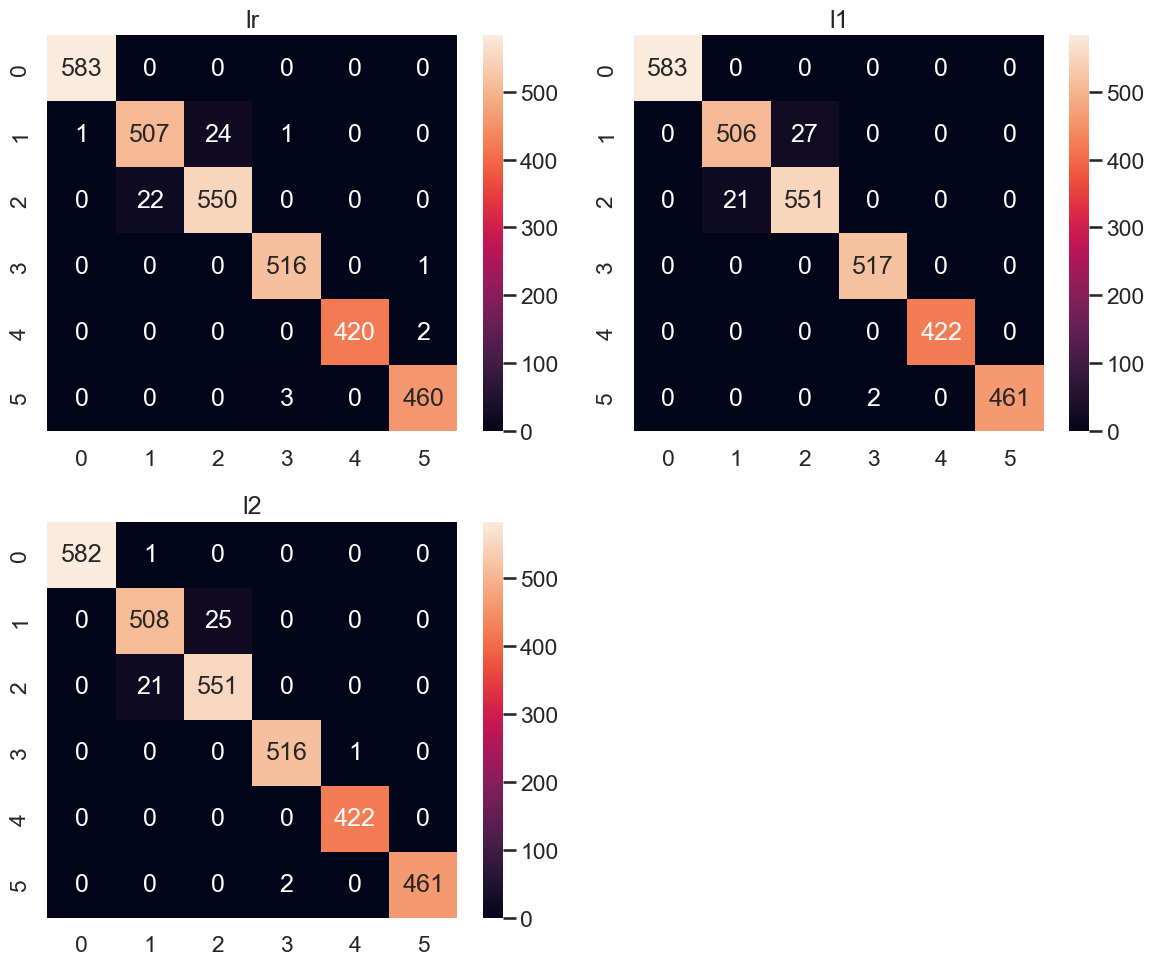

In [26]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


Análise: Pelas matrizes de confisão, percebe-se que existe pouca diferença entre os modelos, com uma pequena melhora utilizando l1 ou l2.

## Question 9
 Identify highly correlated columns and drop those columns before building models

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold


X_data = data.iloc[:, :-1]


#threshold with .7
sel = VarianceThreshold(threshold=(.7 * (1 - .7)))
X_data = pd.DataFrame(sel.fit_transform(X_data))


feature_cols = X_data.columns[:]


# Dividindo os subjconjuntos de treino e teste, seguindo os mesmos
# Indices obtidos com Stratified Shuffle Split, agora com os dados
# Com menos features
 

X_train_new = X_data.loc[train_idx, :]

y_train_new = data.loc[train_idx, 'Activity']
 
X_test_new  = X_data.loc[test_idx, :]
y_test_new  = data.loc[test_idx, 'Activity']
 
print(X_train.shape)
print(X_train_new.shape)
 
print(X_test.shape)

(7209, 561)
(7209, 50)
(3090, 561)


Análise: Foram retiradas as colunas que são altamente correlacionadas, em busca de melhorar o resultado do modelo.

 Repeat Model building with new training data after removing higly correlated columns

In [31]:
# Try standard, L1 and L2 Logistic regression

standard = LogisticRegression(max_iter=100).fit(X_train_new, y_train)
l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear', max_iter=10000).fit(X_train_new, y_train)
l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train_new, y_train)

c:\Users\Arthur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

saga = LogisticRegressionCV(Cs=10, cv=4, solver='saga', max_iter=10000).fit(X_train_new, y_train)
lb = LogisticRegressionCV(Cs=10, cv=4, solver='lbfgs', max_iter=10000).fit(X_train_new, y_train)
nc = LogisticRegressionCV(Cs=10, cv=4, solver='newton-cg', max_iter=10000).fit(X_train_new, y_train)
sag = LogisticRegressionCV(Cs=10, cv=4, solver='sag', max_iter=10000).fit(X_train_new, y_train)

## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [34]:
# Combine all the coefficients into a dataframe for comparison
coefficients = list()

labels_to_models = {
    'standard': standard,
    'standard_l1': l1, 
    'standard_l2':l2,
    'saga': saga,
    'lbfgs': lb,
    'newton-cg': nc,
    'sag': sag
}

for label in labels_to_models.keys():
    coeffs = labels_to_models[label].coef_
    coeff_label = pd.MultiIndex(levels=[[label], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.head()

standard                                                   standard_l1   
          0         1         2         3         4         5           0   
0 -0.388881  0.393567 -0.714766  0.793231 -0.831259  0.748107         0.0  \
1 -0.383481  0.407327 -0.597863  0.974771 -1.754798  1.354043         0.0   
2 -1.227257 -1.764172  0.362765 -1.263930  3.679359  0.213235         0.0   
3  0.043502 -0.412475  0.213688 -1.990773  0.959728  1.186330         0.0   
4 -0.557150 -0.762716  0.036976  1.774280 -2.306584  1.815193         0.0   

                                  ...  newton-cg                         
          1         2          3  ...          2          3          4   
0  0.000000 -1.834030 -76.291549  ... -16.805293 -20.896218  14.283397  \
1  4.445302  0.000000  11.060842  ...   1.091934   4.678025  -4.833619   
2 -9.292362 -1.667427  -5.264929  ...  -3.112455   2.432756  12.110476   
3 -4.327474  0.000000 -57.105127  ...   6.846447 -35.322821  17.610447   
4 -0.575995  1.984079   3.250753  ...  -5.573417   9.068342  -1.343120   

                   sag                                                        
           5         0          1         2          3          4          5  
0   8.009530 -0.302874   5.769653 -6.989758  -5.820555   3.222533   4.121001  
1  -0.196390 -0.377765  -0.251323  0.744581   5.127754  -4.909582  -0.333664  
2   6.089753 -4.361688 -15.210472 -2.487403   2.854140  12.622030   6.583393  
3  13.968079  1.655715  -2.552602  4.101612 -35.718614  18.109361  14.404528  
4   7.204709 -4.497841  -5.715886 -4.269861   8.795908  -1.452323   7.140003  

[5 rows x 42 columns]

Prepare six separate plots for each of the multi-class coefficients.

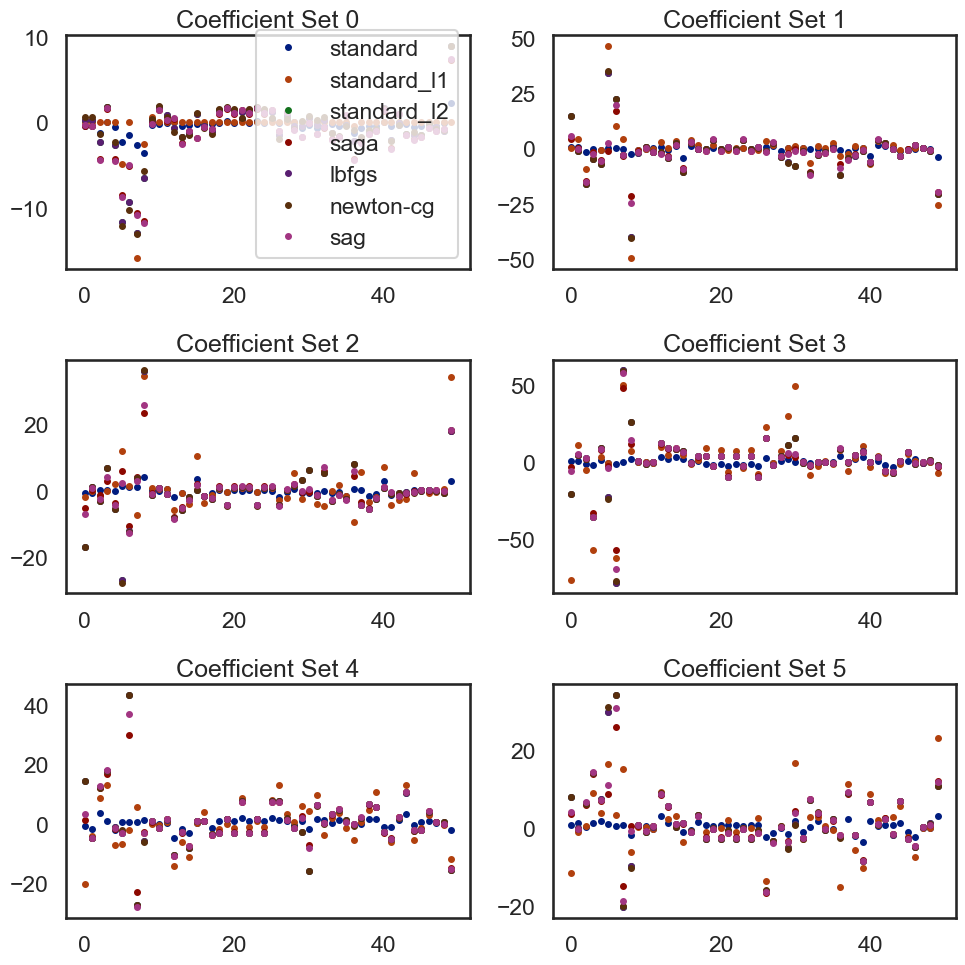

In [35]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=4.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [36]:
# Predict the class and the probability for each
y_pred_new = list()
y_prob_new = list()

for label in labels_to_models.keys():
    y_pred_new.append(pd.Series(labels_to_models[label].predict(X_test_new), name=label))
    y_prob_new.append(pd.Series(labels_to_models[label].predict_proba(X_test_new).max(axis=1), name=label))
    
y_pred_new = pd.concat(y_pred_new, axis=1)
y_prob_new = pd.concat(y_prob_new, axis=1)

y_pred_new.head()

,standard,standard_l1,standard_l2,saga,lbfgs,newton-cg,sag
0,3,3,3,3,3,3,3
1,5,5,5,5,5,5,5
2,3,3,3,3,3,3,3
3,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [37]:
# Calculate the error metrics as listed above
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics_new = list()
cm_new = dict()

for label in labels_to_models.keys():

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred_new[label], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred_new[label])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred_new[label], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm_new[label] = confusion_matrix(y_test, y_pred_new[label])
    
    metrics_new.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=label))

metrics_new = pd.concat(metrics_new, axis=1)

In [38]:
#Run the metrics
metrics_new

,standard,standard_l1,standard_l2,saga,lbfgs,newton-cg,sag
precision,0.925830,0.937318,0.936978,0.937893,0.936978,0.936643,0.937918
recall,0.925890,0.937217,0.936893,0.937864,0.936893,0.936570,0.937864
fscore,0.925843,0.937219,0.936879,0.937838,0.936879,0.936555,0.937849
accuracy,0.925890,0.937217,0.936893,0.937864,0.936893,0.936570,0.937864
auc,0.955426,0.962267,0.962153,0.962707,0.962153,0.961954,0.962714


## Question 13

Display or plot the confusion matrix for each model.

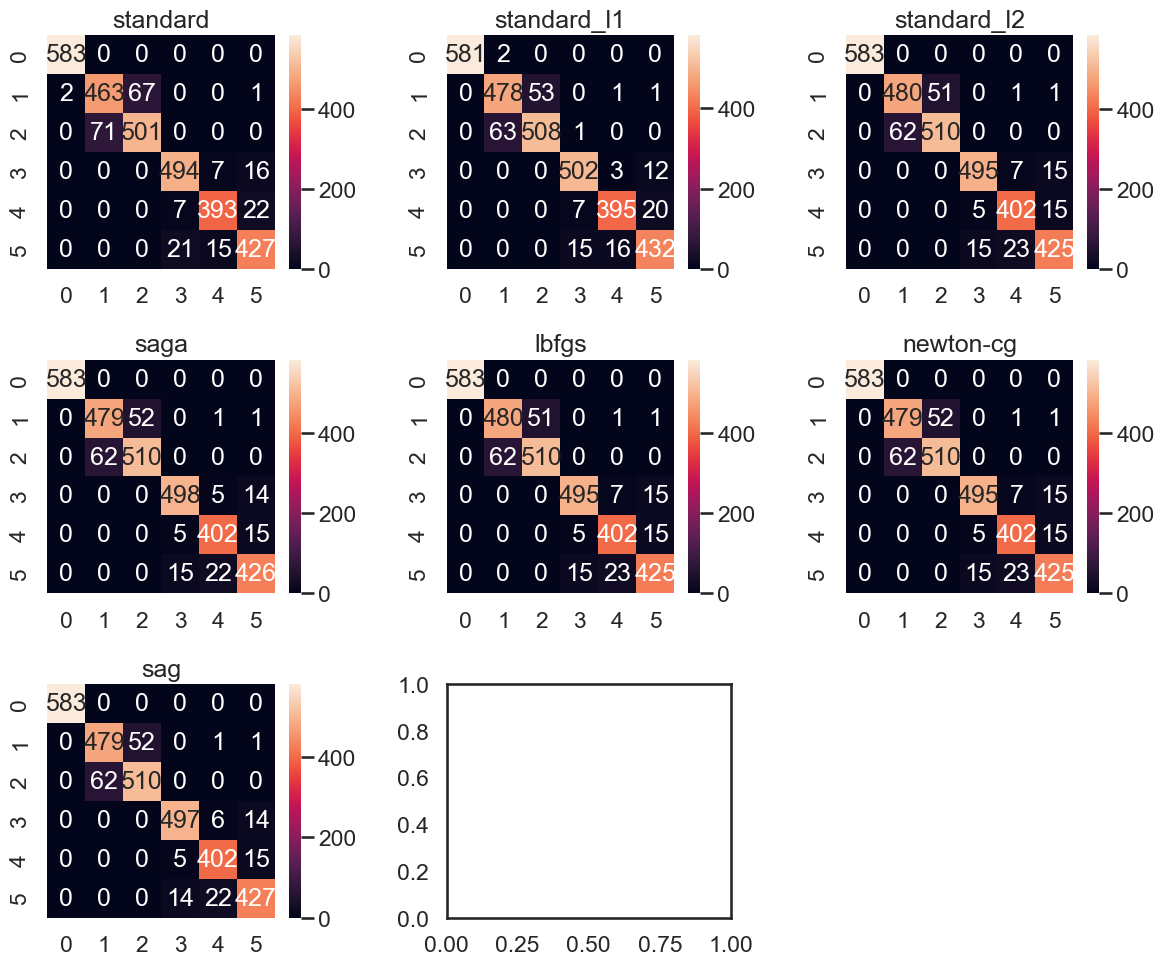

In [46]:
#plot the confusion matrix
fig, axList = plt.subplots(nrows=3, ncols=3)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList, labels_to_models.keys()):
    sns.heatmap(cm_new[lab], ax=ax, annot=True, fmt='d')
    ax.set(title=lab)
    
plt.tight_layout()

In [40]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation
metrics

,lr,l1,l2
precision,0.982506,0.983835,0.983837
recall,0.982524,0.983819,0.983819
fscore,0.982510,0.983815,0.983823
accuracy,0.982524,0.983819,0.983819
auc,0.989385,0.990144,0.990158


In [41]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation
metrics_new

,standard,standard_l1,standard_l2,saga,lbfgs,newton-cg,sag
precision,0.925830,0.937318,0.936978,0.937893,0.936978,0.936643,0.937918
recall,0.925890,0.937217,0.936893,0.937864,0.936893,0.936570,0.937864
fscore,0.925843,0.937219,0.936879,0.937838,0.936879,0.936555,0.937849
accuracy,0.925890,0.937217,0.936893,0.937864,0.936893,0.936570,0.937864
auc,0.955426,0.962267,0.962153,0.962707,0.962153,0.961954,0.962714


Observação: A remoção de features afetou negativamente os resultados do modelo, diminuindo todas as métricas de qualidade em todos os três modelos, além de resultar negativamente em outros modelos testados. Porém, impactou positivamente na performance, já que os modelos foram treinados consideravelmente mais rápido.